# NLP exploration - 4 (executed on Google Colab)
Here we repeat the most promising tests done in previous notebooks (NLP_explore.ipynb, NLP_explore_en.ipynb, NLP_explore_build_recipe.ipynb) for the big recipe database obtained by concatening JOW + 7tomorrow.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import itertools

## Google colab settings
Show the gpu infos and change if needed in "Execution" panel.   
Using GPUs is not compulsory here. I moved to Google Colab because my computer is slow.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 27 15:09:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import from Google Drive.  
Here the folder 'carbondiet4GD' only contains the folder data/ with subfolders Recipes/ and Tools/ (others are not used).

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/carbondiet4GD.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


**Indicate the path where the folder data/ is located.**

In [4]:
#data_path = '../'
data_path = 'carbondiet4GD/'

## Import and prepare the menu database
Import the file that has been prepared with a list of menu recipes and their corresponding 7t and/or JOW recipes.   
Note that the matching has been done by hand in a former step (and may contain errors).

In [5]:
menu_data = pd.read_json(data_path+'data/Tools/MenuTo7tJOWRecipes_v1.json')
menu_data.head(10)

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon,...","[Blue Burger, French Burger, Classic Cheesebur...",no match
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, T...","[Super Bacon Burger, Summer burger]",no match
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",no match,"[awesome turkey burgers, blue cheese stuffed t..."
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette,...","[Tuna bowl, Primavera Poke bowl]",no match
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons br...","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, ..."
6,burgart_205074_c70.jpg,Desserts,Cheesecake maison,None,Cheesecake,no match
7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,None,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw..."
8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,None,Fondant au chocolat,no match
9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,None,"[Financier cerises noires & pistache, Financie...",no match
17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,no match


Check there is no more menu recipes with 'Not yet handled' in the column 'Closest JOW recipe by hand' or 'Closest 7t recipe by hand' and see how many menu recipes we have.

In [6]:
print("Number of not yet handled reicpes = ", menu_data[(menu_data['Closest JOW recipe by hand']=='Not yet handled') | (menu_data['Closest 7t recipe by hand']=='Not yet handled')].shape[0])
print("Total number of menu recipes = ", menu_data.shape[0])
print("Number of menu recipes with 'no match' with JOW = ", menu_data[menu_data['Closest JOW recipe by hand']=='no match'].shape[0])
print("Number of menu recipes with 'no match' with 7t = ", menu_data[menu_data['Closest 7t recipe by hand']=='no match'].shape[0])
print("Number of menu recipes with 'no match', neither with 7t, nor with JOW = ", menu_data[(menu_data['Closest 7t recipe by hand']=='no match') & (menu_data['Closest JOW recipe by hand']=='no match')].shape[0])
print("Number of menu recipes with 'match' with JOW = ", menu_data[menu_data['Closest JOW recipe by hand']!='no match'].shape[0])
print("Number of menu recipes with 'match' with 7t = ", menu_data[menu_data['Closest 7t recipe by hand']!='no match'].shape[0])
print("Number of menu recipes with 'match' with both JOW & 7t = ", menu_data[(menu_data['Closest 7t recipe by hand']!='no match') & (menu_data['Closest JOW recipe by hand']!='no match')].shape[0])

Number of not yet handled reicpes =  0
Total number of menu recipes =  60
Number of menu recipes with 'no match' with JOW =  16
Number of menu recipes with 'no match' with 7t =  41
Number of menu recipes with 'no match', neither with 7t, nor with JOW =  10
Number of menu recipes with 'match' with JOW =  44
Number of menu recipes with 'match' with 7t =  19
Number of menu recipes with 'match' with both JOW & 7t =  13


Prepare the list of queries for test, first by concatenating the title and subtitle of menu recipes 

In [7]:
menu_data['Menu Title and Subtitle'] = menu_data.apply(lambda row: row['Menu Title'] + ", " + row['Menu Subtitle'], axis = 1)
menu_data.head()

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon,...","[Blue Burger, French Burger, Classic Cheesebur...",no match,"Burgers, Superfin"
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, T...","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau"
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",no match,"[awesome turkey burgers, blue cheese stuffed t...","Burgers, Green Chicken"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette,...","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl"
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons br...","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, ...","Salades, Crispy Caesar"


Replace NaN in the ingredients column by empty string

In [8]:
menu_data = menu_data.fillna("")
menu_data.head()

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon,...","[Blue Burger, French Burger, Classic Cheesebur...",no match,"Burgers, Superfin"
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, T...","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau"
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",no match,"[awesome turkey burgers, blue cheese stuffed t...","Burgers, Green Chicken"
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette,...","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl"
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons br...","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, ...","Salades, Crispy Caesar"


Do the same by concatenating the title, subtitle and ingredients of menu recipes

In [9]:
def add_ingredients(row):
    if row['Menu Ingredients']=='':
        res = row['Menu Title'] + ", " + row['Menu Subtitle']
    else:
        res = row['Menu Title'] + ", " + row['Menu Subtitle'] + ", " + row['Menu Ingredients']
    return res

menu_data['Menu all'] = menu_data.apply(add_ingredients, axis = 1)
menu_data.head(8)

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon,...","[Blue Burger, French Burger, Classic Cheesebur...",no match,"Burgers, Superfin","Burgers, Superfin, Bœuf (VBF Metzger), Comté A..."
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, T...","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau","Burgers, Bon & Beau, Bœuf (VBF Metzger), Chedd..."
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",no match,"[awesome turkey burgers, blue cheese stuffed t...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme..."
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette,...","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl","Poke Bowls, Black bowl, Thon, Riz noir, Avocat..."
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons br...","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, ...","Salades, Crispy Caesar","Salades, Crispy Caesar, Croquettes de poulet, ..."
6,burgart_205074_c70.jpg,Desserts,Cheesecake maison,,Cheesecake,no match,"Desserts, Cheesecake maison","Desserts, Cheesecake maison"
7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"


**We keep only menu recipes that have been successfully matched -by hand- with either JOW or 7t recipes.**

In [10]:
menu_data_withmatch = menu_data[(menu_data['Closest 7t recipe by hand']!='no match') | (menu_data['Closest JOW recipe by hand']!='no match')]
print("Number of queries = ", menu_data_withmatch.shape[0])

Number of queries =  50


In [11]:
menu_data_withmatch

,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Closest 7t recipe by hand,Menu Title and Subtitle,Menu all
0,burgart_205074_c70.jpg,Burgers,Superfin,"Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon,...","[Blue Burger, French Burger, Classic Cheesebur...",no match,"Burgers, Superfin","Burgers, Superfin, Bœuf (VBF Metzger), Comté A..."
1,burgart_205074_c70.jpg,Burgers,Bon & Beau,"Bœuf (VBF Metzger), Cheddar, Sucrine, Bacon, T...","[Super Bacon Burger, Summer burger]",no match,"Burgers, Bon & Beau","Burgers, Bon & Beau, Bœuf (VBF Metzger), Chedd..."
3,burgart_205074_c70.jpg,Burgers,Green Chicken,"Filet de poulet, Tomme de Savoie IGP, Roquette...",no match,"[awesome turkey burgers, blue cheese stuffed t...","Burgers, Green Chicken","Burgers, Green Chicken, Filet de poulet, Tomme..."
4,burgart_205074_c70.jpg,Poke Bowls,Black bowl,"Thon, Riz noir, Avocat, Oignon rouge, Cébette,...","[Tuna bowl, Primavera Poke bowl]",no match,"Poke Bowls, Black bowl","Poke Bowls, Black bowl, Thon, Riz noir, Avocat..."
5,burgart_205074_c70.jpg,Salades,Crispy Caesar,"Croquettes de poulet, Parmesan, Champignons br...","[Salade César, Salade au poulet pané]","[better-for-you grilled chicken caesar salad, ...","Salades, Crispy Caesar","Salades, Crispy Caesar, Croquettes de poulet, ..."
6,burgart_205074_c70.jpg,Desserts,Cheesecake maison,,Cheesecake,no match,"Desserts, Cheesecake maison","Desserts, Cheesecake maison"
7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"[chocolate mousse, chocolate dream mousse, raw...","Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,no match,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"[Financier cerises noires & pistache, Financie...",no match,"Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger"
19,Carte-in-seoul.png,Anju,Sewoo kkanpoong (8 pcs),Crevettes frites dans une sauce aigre douce,"[Crevettes teriyaki, Crevettes miel sésame]",no match,"Anju, Sewoo kkanpoong (8 pcs)","Anju, Sewoo kkanpoong (8 pcs), Crevettes frite..."


## Import and prepare the JOW database

In [12]:
jow_data = pd.read_json(data_path + 'data/Recipes/recipes_jow.json')
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data['recipe_name'] = jow_data.index
jow_data.head()

,cuisson,ingredients,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


We remove ligatures, e.g. Bœuf -> Boeuf.  
This is probably useless.

In [13]:
REGEX_REPLACEMENTS = [(r"\u0153", "oe"), \
                      (r"\u0152", "Oe")]

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

#jow_data['recipe_name'] = jow_data['recipe_name'].apply(lambda s: remove_ligatures(str(s)))
jow_data = jow_data.rename({'ingredients': 'ingredients_with_quantity'}, axis = 1)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


Let's add a column for ingredients only (no quantity, informations in parenthesis are removed)

In [14]:
# Known from previous notebook '[Genevieve] ingredients_scores__process.ipynb'
meaningless_jow_ingredients = ['1/10 bou.', '1/5 bou.', '1/50 bou.', '6 pinc.', '1 càc', '1/4', '3 pinc.', '2 càs', \
                               '1 cm', '1/20 bou.', '1 càs', '1/2 càc', 'Papier cuisson', 'Pics à brochette']

def extract_ingredients(row):
    ingredients = []
    for x in row:
        if len(x)>1:         
            ingredient = x[-1]    # the ingredient is the last element of the list 'row'  
            if ingredient not in meaningless_jow_ingredients:   # keep only meaningfull ingredients
                ingredient = remove_ligatures(ingredient)
                ingredients.append(ingredient) 

    ingredients = [re.sub("[\(\[].*?[\)\]]", "", ingredient) for ingredient in ingredients]  #remove informations in parenthesis
    # remove blank at the end of the string that remained when parenthesis have been removed
    ingredients = [ing[:-1] if ing[-1]==" " else ing for ing in ingredients]   

    return ingredients

jow_data['ingredients'] = jow_data['ingredients_with_quantity'].apply(extract_ingredients)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail,"[Lentilles corail, Tomate, Lait de coco, Ail]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna,"[Lasagnes, Courgette, Tomate, Champignons de Paris, Mozzarella]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, oeuf, Parmesan]"


Add the column 'name_with_ingredients' by concatenating recipe names and ingredients

In [15]:
jow_data['name_with_ingredients'] = jow_data.apply(lambda row: row['recipe_name'] + ", " + ', '.join(row['ingredients']), axis = 1)
jow_data.head(2)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]","Yakitori bœuf fromage, Boeuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


##Import the 7t recipe database translated in french

In [16]:
seven_path = data_path + 'data/Recipes/recettes_completes_7tomorrow_preprocessed.json'
seven_data = pd.read_json(seven_path)
seven_data.head()

,title_raw,title_raw_fr,ingredient_basics,ingredient_basics_fr,ingredient_basics_with_qty,ingredient_basics_with_qty_fr
0,""" child's play"" sour pops","""Play de l'enfant"" Sour Pops","[lime juice, lemon juice]","[jus de citron vert, jus de citron]","[[726.0 g, lime juice], [732.0 g, lemon juice]]","[[726.0 g, jus de citron vert], [732.0 g, jus de citron]]"
1,""" fried egg sundaes""","""Sundaes aux œufs au plat""","[ice cream, cream, spice]","[glace, crème, épices]","[[1584.0 g, ice cream], [50.0 g, cream], [5.1 g, spice]]","[[1584.0 g, glace], [50.0 g, crème], [5.1 g, épices]]"
2,""" world's best ""( and easiest ) teriyaki chicken wings","""Best du monde"" (et les plus faciles) Ailes de poulet Teriyaki","[chicken, soy sauce soy, sugar]","[poulet, sauce de soja, du sucre]","[[2267.96 g, chicken], [283.5 g, soy sauce soy], [453.59 g, sugar]]","[[2267.96 g, poulet], [283.5 g, sauce de soja], [453.59 g, du sucre]]"
3,"""apple crisp"" peanut butter snack bites","Bites de collations au beurre d'arachide ""pomme croustillante""","[peanut butter, honey, oat, nut, apple, spice]","[beurre d'arachide, miel, avoine, noix, Pomme, épices]","[[128.0 g, peanut butter], [84.75 g, honey], [156.0 g, oat], [58.5 g, nut], [41.67 g, apple], [1.3 g, spice]]","[[128.0 g, beurre d'arachide], [84.75 g, miel], [156.0 g, avoine], [58.5 g, noix], [41.67 g, Pomme], [1.3 g, épices]]"
4,"""berry good"" smoothie","Smoothie ""Berry Good""","[apple juice, strawberry, raspberry, blackberry, blueberry]","[jus de pomme, fraise, framboise, la mûre, myrtille]","[[372.0 g, apple juice], [1824.0 g, strawberry], [1476.0 g, raspberry], [2016.0 g, blackberry], [2072.0 g, blueberry]]","[[372.0 g, jus de pomme], [1824.0 g, fraise], [1476.0 g, framboise], [2016.0 g, la mûre], [2072.0 g, myrtille]]"


Remove doublons in ingredient lists

In [17]:
seven_data['ingredient_basics'] = seven_data['ingredient_basics'].apply(lambda l: list(set(l)))    
seven_data['ingredient_basics_fr'] = seven_data['ingredient_basics_fr'].apply(lambda l: list(set(l)))

In [18]:
seven_data.head(2)

,title_raw,title_raw_fr,ingredient_basics,ingredient_basics_fr,ingredient_basics_with_qty,ingredient_basics_with_qty_fr
0,""" child's play"" sour pops","""Play de l'enfant"" Sour Pops","[lime juice, lemon juice]","[jus de citron, jus de citron vert]","[[726.0 g, lime juice], [732.0 g, lemon juice]]","[[726.0 g, jus de citron vert], [732.0 g, jus de citron]]"
1,""" fried egg sundaes""","""Sundaes aux œufs au plat""","[cream, ice cream, spice]","[épices, crème, glace]","[[1584.0 g, ice cream], [50.0 g, cream], [5.1 g, spice]]","[[1584.0 g, glace], [50.0 g, crème], [5.1 g, épices]]"


Concatenate recipe names and ingredients

In [19]:
seven_data['name_with_ingredients'] = seven_data.apply(lambda row: row['title_raw'] + ", " + ', '.join(row['ingredient_basics']), axis = 1)        
seven_data['name_with_ingredients_fr'] = seven_data.apply(lambda row: row['title_raw_fr'] + ", " +  ', '.join(row['ingredient_basics_fr']), axis = 1)

In [20]:
seven_data.head()

,title_raw,title_raw_fr,ingredient_basics,ingredient_basics_fr,ingredient_basics_with_qty,ingredient_basics_with_qty_fr,name_with_ingredients,name_with_ingredients_fr
0,""" child's play"" sour pops","""Play de l'enfant"" Sour Pops","[lime juice, lemon juice]","[jus de citron, jus de citron vert]","[[726.0 g, lime juice], [732.0 g, lemon juice]]","[[726.0 g, jus de citron vert], [732.0 g, jus de citron]]",""" child's play"" sour pops, lime juice, lemon juice","""Play de l'enfant"" Sour Pops, jus de citron, jus de citron vert"
1,""" fried egg sundaes""","""Sundaes aux œufs au plat""","[cream, ice cream, spice]","[épices, crème, glace]","[[1584.0 g, ice cream], [50.0 g, cream], [5.1 g, spice]]","[[1584.0 g, glace], [50.0 g, crème], [5.1 g, épices]]",""" fried egg sundaes"", cream, ice cream, spice","""Sundaes aux œufs au plat"", épices, crème, glace"
2,""" world's best ""( and easiest ) teriyaki chicken wings","""Best du monde"" (et les plus faciles) Ailes de poulet Teriyaki","[soy sauce soy, chicken, sugar]","[sauce de soja, du sucre, poulet]","[[2267.96 g, chicken], [283.5 g, soy sauce soy], [453.59 g, sugar]]","[[2267.96 g, poulet], [283.5 g, sauce de soja], [453.59 g, du sucre]]",""" world's best ""( and easiest ) teriyaki chicken wings, soy sauce soy, chicken, sugar","""Best du monde"" (et les plus faciles) Ailes de poulet Teriyaki, sauce de soja, du sucre, poulet"
3,"""apple crisp"" peanut butter snack bites","Bites de collations au beurre d'arachide ""pomme croustillante""","[honey, nut, spice, apple, peanut butter, oat]","[épices, noix, Pomme, miel, avoine, beurre d'arachide]","[[128.0 g, peanut butter], [84.75 g, honey], [156.0 g, oat], [58.5 g, nut], [41.67 g, apple], [1.3 g, spice]]","[[128.0 g, beurre d'arachide], [84.75 g, miel], [156.0 g, avoine], [58.5 g, noix], [41.67 g, Pomme], [1.3 g, épices]]","""apple crisp"" peanut butter snack bites, honey, nut, spice, apple, peanut butter, oat","Bites de collations au beurre d'arachide ""pomme croustillante"", épices, noix, Pomme, miel, avoine, beurre d'arachide"
4,"""berry good"" smoothie","Smoothie ""Berry Good""","[blueberry, apple juice, blackberry, raspberry, strawberry]","[framboise, fraise, myrtille, jus de pomme, la mûre]","[[372.0 g, apple juice], [1824.0 g, strawberry], [1476.0 g, raspberry], [2016.0 g, blackberry], [2072.0 g, blueberry]]","[[372.0 g, jus de pomme], [1824.0 g, fraise], [1476.0 g, framboise], [2016.0 g, la mûre], [2072.0 g, myrtille]]","""berry good"" smoothie, blueberry, apple juice, blackberry, raspberry, strawberry","Smoothie ""Berry Good"", framboise, fraise, myrtille, jus de pomme, la mûre"


Rename the columns to be consistent with JOW

In [21]:
dict_rename = {'ingredient_basics_with_qty': 'ingredients_with_quantity_en', \
               'ingredient_basics_with_qty_fr': 'ingredients_with_quantity', \
               'title_raw': 'recipe_name_en', \
               'title_raw_fr': 'recipe_name', \
               'ingredient_basics': 'ingredients_en', \
               'ingredient_basics_fr': 'ingredients', \
               'name_with_ingredients': 'name_with_ingredients_en', \
               'name_with_ingredients_fr': 'name_with_ingredients'}

seven_data = seven_data.rename(dict_rename, axis = 1)
seven_data.head(2)

,recipe_name_en,recipe_name,ingredients_en,ingredients,ingredients_with_quantity_en,ingredients_with_quantity,name_with_ingredients_en,name_with_ingredients
0,""" child's play"" sour pops","""Play de l'enfant"" Sour Pops","[lime juice, lemon juice]","[jus de citron, jus de citron vert]","[[726.0 g, lime juice], [732.0 g, lemon juice]]","[[726.0 g, jus de citron vert], [732.0 g, jus de citron]]",""" child's play"" sour pops, lime juice, lemon juice","""Play de l'enfant"" Sour Pops, jus de citron, jus de citron vert"
1,""" fried egg sundaes""","""Sundaes aux œufs au plat""","[cream, ice cream, spice]","[épices, crème, glace]","[[1584.0 g, ice cream], [50.0 g, cream], [5.1 g, spice]]","[[1584.0 g, glace], [50.0 g, crème], [5.1 g, épices]]",""" fried egg sundaes"", cream, ice cream, spice","""Sundaes aux œufs au plat"", épices, crème, glace"


Keep only columns in french

In [22]:
seven_data_fr = seven_data[['ingredients_with_quantity', 'recipe_name', 'ingredients', 'name_with_ingredients']]
seven_data_fr.head(2)

,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
0,"[[726.0 g, jus de citron vert], [732.0 g, jus de citron]]","""Play de l'enfant"" Sour Pops","[jus de citron, jus de citron vert]","""Play de l'enfant"" Sour Pops, jus de citron, jus de citron vert"
1,"[[1584.0 g, glace], [50.0 g, crème], [5.1 g, épices]]","""Sundaes aux œufs au plat""","[épices, crème, glace]","""Sundaes aux œufs au plat"", épices, crème, glace"


## Concatenate the 2 databases

In [23]:
jow_data = jow_data[['ingredients_with_quantity', 'recipe_name', 'ingredients', 'name_with_ingredients']]

In [24]:
jow_data.head(2)

,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]","Yakitori bœuf fromage, Boeuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


In [25]:
jow_7t_data = pd.concat([jow_data, seven_data_fr], axis = 0)

In [26]:
print("Number of recipes in jow_7t_data = ", jow_7t_data.shape[0])

Number of recipes in jow_7t_data =  8824


## Pre-matching with NLP

In [27]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from sentence_transformers import SentenceTransformer, util
model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

We need first to compute the embedding of JOW+7t recipes labeled with 'name_with_ingredients'.

In [29]:
t0 = time.time()
jow7t_fullname_recipes = list(jow_7t_data['name_with_ingredients'].values)
jow7t_fullname_embeddings = model.encode(jow7t_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW+7t embedding (s) = ", time.time()-t0)

Time lapse for JOW+7t embedding (s) =  50.469024658203125


For each menu recipe, we want to select with NLP all recipes in JOW+7t whose similary score s is larger than max_score - radius (for each menu recipe, max_score is the similarity score of the JOW+7t recipe that is the closest to the menu recipe).

In [30]:
# Function that returns the hits in data_base corresponding to the query,
# whose similarity scores are among the top_k biggest scores and larger than max_score - radius
def most_similar_recipes(query, database_embedding, model, top_k = 20, radius = 0.1):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, database_embedding, top_k = top_k)    #find the top_k closest database recipes from query
    hits = hits[0]      #Get the hits for the first query (here only one query is given)

    # Keep only the recipes whose similarity scores are highest that max_score - radius
    best_hits = []
    for k, hit in enumerate(hits):
        max_score = hits[0]['score']  # hits is stored by descending scores
        if hit['score'] > max_score - radius:
            best_hits.append(hit)

    return best_hits


# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow7t_fullname_recipe = jow7t_fullname_recipes[hit['corpus_id']]
            jow7t_recipe = jow_7t_data[jow_7t_data['name_with_ingredients']==jow7t_fullname_recipe]['recipe_name'].values[0]
            
        
            # See if matching for this query had been found by hand
            closest_jow = row['Closest JOW recipe by hand']    # recipe in french
            closest_7t_en = row['Closest 7t recipe by hand']      # recipe in english

            # ... translate closest_7t_en in french
            if isinstance(closest_7t_en, list):
                # list of corresponding recipes in french
                closest_7t = [seven_data[seven_data['recipe_name_en']==recipe]['recipe_name'].values[0] for recipe in closest_7t_en]
            elif closest_7t_en!='no match':
                # corresponding recipe in french
                closest_7t = seven_data[seven_data['recipe_name_en']==closest_7t_en]['recipe_name'].values[0]  
            else:
                closest_7t = 'no match'

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_jow, list):
                matched_jow_idx = 1 if jow7t_recipe in closest_jow else 0
            else:
                matched_jow_idx = 1 if jow7t_recipe==closest_jow else 0

            if isinstance(closest_7t, list):
                matched_7t_idx = 1 if jow7t_recipe in closest_7t else 0
            else:
                matched_7t_idx = 1 if jow7t_recipe==closest_7t else 0

            matched_idx = max(matched_jow_idx, matched_7t_idx)

            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, jow7t_recipe, k+1, hit['score'], matched_jow_idx, matched_7t_idx, matched_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow7t_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_jow', 'is_matched_7t', 'is_matched_tot'])\
                                    .reset_index(drop = True)

    return data_res



Run the NLP model by considering the full label of menu recipes (title+subtitle+ingredients if any) and the jow+7t recipes' names+ingredients (no quantity).   
**Remember this is run here only for menu recipes having at least one explicit match by hand with JOW or 7t.**

In [31]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step1 = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu all', jow7t_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step1 = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu all', jow7t_fullname_embeddings, model, top_k = top_k, radius = 1)
df_res_step1

,menu_recipe_label,jow7t_guess,similarity_rank,similarity_score,is_matched_jow,is_matched_7t,is_matched_tot
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,0,1
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",French Burger,2,0.721682,1,0,1
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Brunch Burger,3,0.706234,0,0,0
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Super Bacon Burger,4,0.696295,1,0,1
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Blue Burger,5,0.684877,1,0,1
...,...,...,...,...,...,...,...
245,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse purée & épinards,1,0.711127,1,0,1
246,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",purée de pommes de terre à la truffe,2,0.700466,0,0,0
247,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse & purée maison,3,0.687571,1,0,1
248,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Grilled cheese cochon à la truffe,4,0.680487,0,0,0


Add the columns with matchings done by hand

In [32]:
df_res_step1['Closest JOW recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step1['Closest 7t recipe by hand'] = df_res_step1['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step1

,menu_recipe_label,jow7t_guess,similarity_rank,similarity_score,is_matched_jow,is_matched_7t,is_matched_tot,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,0,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",French Burger,2,0.721682,1,0,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Brunch Burger,3,0.706234,0,0,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Super Bacon Burger,4,0.696295,1,0,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Blue Burger,5,0.684877,1,0,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
...,...,...,...,...,...,...,...,...,...
245,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse purée & épinards,1,0.711127,1,0,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
246,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",purée de pommes de terre à la truffe,2,0.700466,0,0,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
247,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse & purée maison,3,0.687571,1,0,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
248,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Grilled cheese cochon à la truffe,4,0.680487,0,0,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"


Let's have a closer look at menu recipes that have not been successfully matched

In [33]:
recipes_notmatched = df_res_step1[(df_res_step1['is_matched_tot']==0) & (df_res_step1['similarity_rank']==1)]['menu_recipe_label'].values.tolist()
print(len(recipes_notmatched))

df_res_step1[df_res_step1['menu_recipe_label'].isin(recipes_notmatched)]

23


,menu_recipe_label,jow7t_guess,similarity_rank,similarity_score,is_matched_jow,is_matched_7t,is_matched_tot,Closest JOW recipe by hand,Closest 7t recipe by hand
10,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Italian burger,1,0.741322,0,0,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
11,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Cheeseburger veggie,2,0.718946,0,0,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
12,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Tom burger,3,0.714138,0,0,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
13,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Classic Cheeseburger,4,0.707396,0,0,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
14,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",French Burger,5,0.700665,0,0,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
...,...,...,...,...,...,...,...,...,...
235,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard aux patates douces,1,0.675605,0,0,0,"[Parmentier de canard, Magret de canard & purée]",no match
236,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard,2,0.635657,1,0,1,"[Parmentier de canard, Magret de canard & purée]",no match
237,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard & purée,3,0.634149,1,0,1,"[Parmentier de canard, Magret de canard & purée]",no match
238,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard à l'orange,4,0.633614,0,0,0,"[Parmentier de canard, Magret de canard & purée]",no match


In [34]:
print("Number of good matchings among outputs with rank 1 :")
df_res_step1[(df_res_step1['similarity_rank']==1) & (df_res_step1['is_matched_tot']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


27

In [35]:
print("Number of good matchings among outputs with rank 1 which match JOW:")
df_res_step1[(df_res_step1['similarity_rank']==1) & (df_res_step1['is_matched_jow']==1)].shape[0]

Number of good matchings among outputs with rank 1 which match JOW:


24

In [36]:
print("Number of good matchings among outputs with rank 1 which match 7t:")
df_res_step1[(df_res_step1['similarity_rank']==1) & (df_res_step1['is_matched_7t']==1)].shape[0]

Number of good matchings among outputs with rank 1 which match 7t:


3

In [37]:
df_tmp = pd.DataFrame(df_res_step1.groupby('menu_recipe_label')['is_matched_tot'].agg(sum))
df_tmp['is_matched_tot'] = df_tmp['is_matched_tot'].apply(lambda x: x if x==0 else 1)

print("Number of good matchings among the cloud of pre-selected recipes :")
df_tmp[df_tmp['is_matched_tot']==1].shape[0]

Number of good matchings among the cloud of pre-selected recipes :


37

There are some menu recipes for which we had a match when using the NLP model for the database 7t only while the match is lost when the full database (jow+7t) is used, eg:  
- Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz  

There are some menu recipes for which we had a match when using the NLP model for the database JOW only while the match is lost when the full database (jow+7t) is used, eg:  
- Desserts, Mousse au chocolat maison  

There are also some menu recipes for which we had no match when using the NLP model for the database JOW only while we have a match when the full database (jow+7t) is used, eg:  
- Sides, Frites, (v)

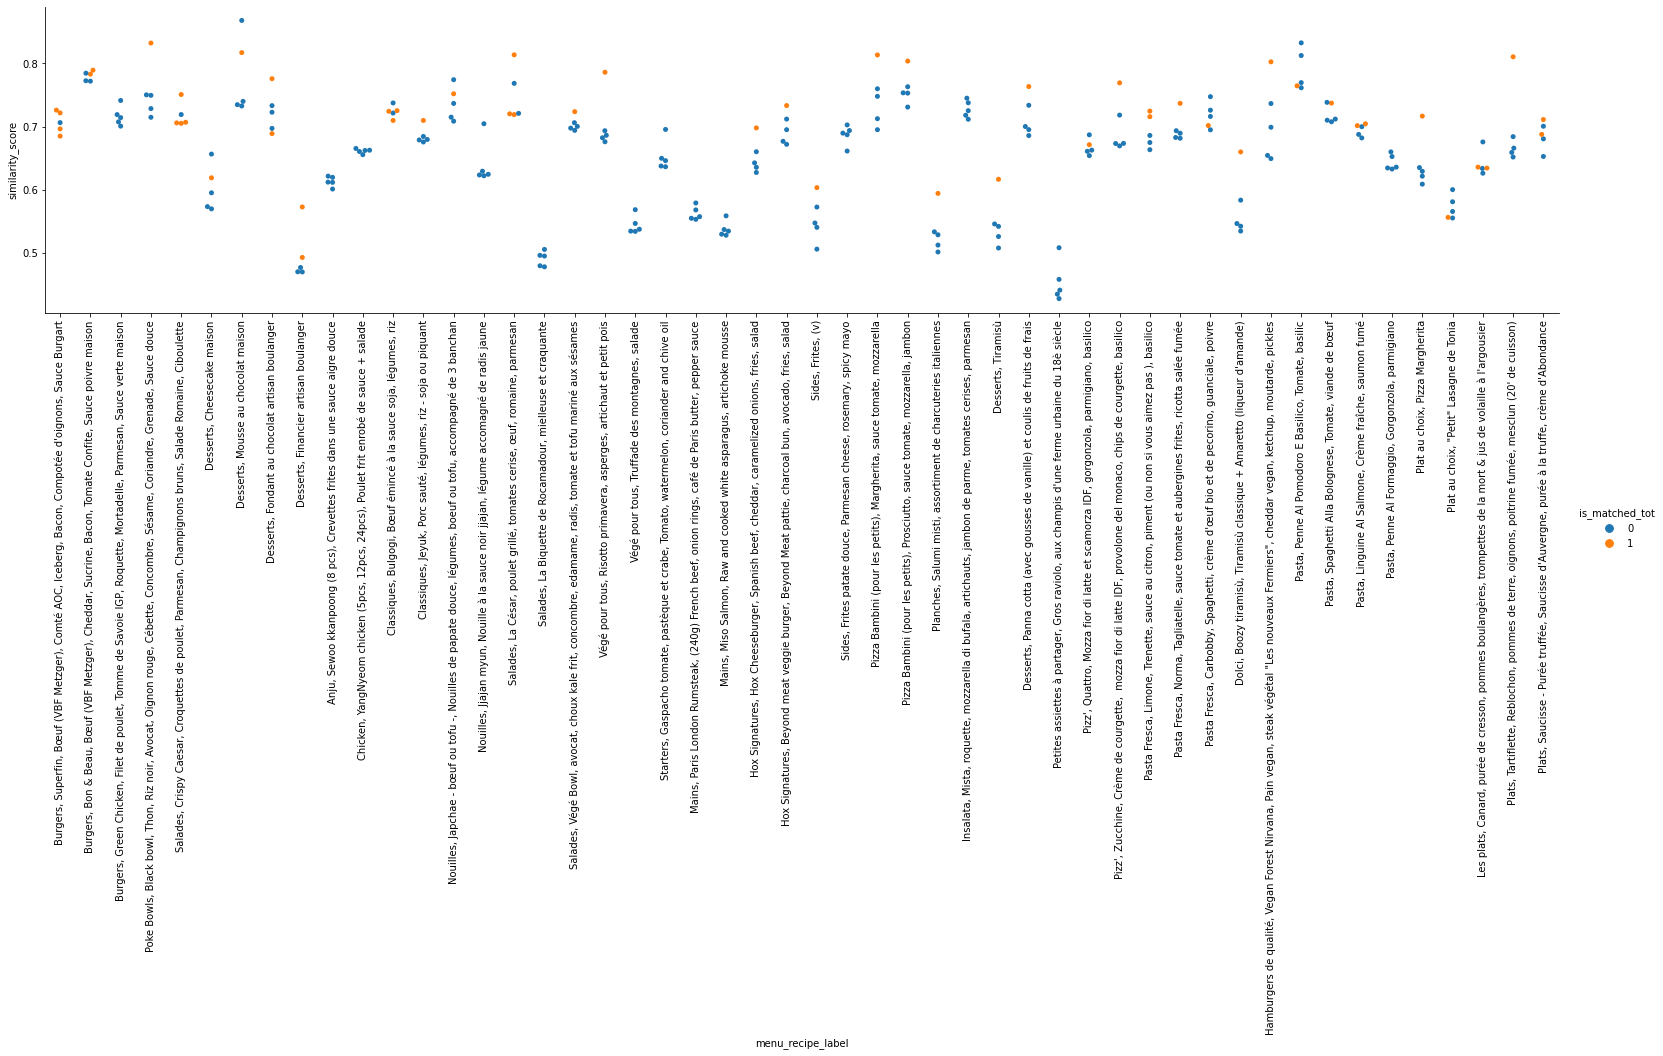

In [38]:
fig = sns.catplot(data = df_res_step1, x = 'menu_recipe_label', y = 'similarity_score',  \
                  hue = 'is_matched_tot', kind = 'swarm', aspect = 5)
fig.set_xticklabels(rotation=90);

Let's have a look at predictions for recipes which could not be matched by hand

In [39]:
menu_data_nomatch = menu_data[(menu_data['Closest 7t recipe by hand']=='no match') & (menu_data['Closest JOW recipe by hand']=='no match')]
print("Number of queries = ", menu_data_nomatch.shape[0])

Number of queries =  10


In [40]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step1 = find_and_store_most_similar_recipes(menu_data_nomatch, 'Menu all', jow7t_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step2 = find_and_store_most_similar_recipes(menu_data_nomatch, 'Menu all', jow7t_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step2['Closest JOW recipe by hand'] = df_res_step2['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step2['Closest 7t recipe by hand'] = df_res_step2['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step2

,menu_recipe_label,jow7t_guess,similarity_rank,similarity_score,is_matched_jow,is_matched_7t,is_matched_tot,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",Recette de filet de porc grillé grillé,1,0.640620,0,0,0,no match,no match
1,"Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",brochettes de porc grillées avec gingembre,2,0.634679,0,0,0,no match,no match
2,"Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",Salade de porc et de nouilles de style thaïlandais,3,0.628194,0,0,0,no match,no match
3,"Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",recette chinoise de porc grillé (ch'a hsao),4,0.625431,0,0,0,no match,no match
4,"Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes",Nouilles de riz & porc sauté,5,0.619716,0,0,0,no match,no match
5,"Anju, Haemul Jeol, Galette de fruit mer",Galette complète,1,0.449843,0,0,0,no match,no match
6,"Anju, Haemul Jeol, Galette de fruit mer",Eggs & salmon muffins,2,0.438509,0,0,0,no match,no match
7,"Anju, Haemul Jeol, Galette de fruit mer","Poisson pané, purée & haricots verts",3,0.429313,0,0,0,no match,no match
8,"Anju, Haemul Jeol, Galette de fruit mer",Tilapia en croûte de pacan,4,0.426207,0,0,0,no match,no match
9,"Anju, Haemul Jeol, Galette de fruit mer",Galette Seguin,5,0.425963,0,0,0,no match,no match


## Repeat the NLP task by considering only the JOW database

Compute the embedding of JOW recipes labeled with 'name_with_ingredients'.

In [41]:
t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings = model.encode(jow_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  9.306087493896484


For each menu recipe, we want to select with NLP all recipes in JOW whose similary score s is larger than max_score - radius (for each menu recipe, max_score is the similarity score of the JOW recipe that is the closest to the menu recipe).

In [49]:
# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
            jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe].index[0]
        
            # See if matching for this query had been found by hand
            closest_jow = row['Closest JOW recipe by hand']    # recipe in french

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_jow, list):
                matched_jow_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_jow_idx = 1 if jow_recipe==closest_jow else 0


            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, jow_recipe, k+1, hit['score'], matched_jow_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_jow'])\
                                    .reset_index(drop = True)

    return data_res



Let's first look at predictions for recipes which could be matched by hand

In [50]:
menu_data_withmatchjow = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatchjow.shape[0])

Number of queries =  44


In [51]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step3 = find_and_store_most_similar_recipes(menu_data_withmatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step3 = find_and_store_most_similar_recipes(menu_data_withmatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step3['Closest JOW recipe by hand'] = df_res_step3['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step3['Closest 7t recipe by hand'] = df_res_step3['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step3

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Burger raclette,1,0.726083,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",French Burger,2,0.721682,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Brunch Burger,3,0.706234,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Super Bacon Burger,4,0.696295,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",Blue Burger,5,0.684877,1,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
...,...,...,...,...,...,...,...
215,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse purée & épinards,1,0.711127,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
216,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse & purée maison,2,0.687571,1,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
217,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Grilled cheese cochon à la truffe,3,0.680487,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
218,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Saucisse aux oignons,4,0.652563,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"


In [52]:
print("Number of good matchings among outputs with rank 1 :")
df_res_step3[(df_res_step3['similarity_rank']==1) & (df_res_step3['is_matched_jow']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


28

In [53]:
df_tmp = pd.DataFrame(df_res_step3.groupby('menu_recipe_label')['is_matched_jow'].agg(sum))
df_tmp['is_matched_jow'] = df_tmp['is_matched_jow'].apply(lambda x: x if x==0 else 1)

print("Number of good matchings among the cloud of pre-selected recipes :")
df_tmp[df_tmp['is_matched_jow']==1].shape[0]

Number of good matchings among the cloud of pre-selected recipes :


37

Let's have a closer look at menu recipes that have not been successfully matched

In [54]:
recipes_notmatched2 = df_res_step3[(df_res_step3['is_matched_jow']==0) & (df_res_step3['similarity_rank']==1)]['menu_recipe_label'].values.tolist()
print(len(recipes_notmatched2))

df_res_step3[df_res_step3['menu_recipe_label'].isin(recipes_notmatched2)]

16


,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
40,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Poêlée crevettes & légumes express,1,0.621381,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
41,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Nouilles sautées aux crevettes,2,0.600914,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
42,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Pad Thaï crevette,3,0.594309,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
43,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Nouilles de riz & porc sauté,4,0.571034,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
44,"Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce",Riz sauté aux crevettes,5,0.565556,0,"[Crevettes teriyaki, Crevettes miel sésame]",no match
...,...,...,...,...,...,...,...
205,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard aux patates douces,1,0.675605,0,"[Parmentier de canard, Magret de canard & purée]",no match
206,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Parmentier de canard,2,0.635657,1,"[Parmentier de canard, Magret de canard & purée]",no match
207,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard & purée,3,0.634149,1,"[Parmentier de canard, Magret de canard & purée]",no match
208,"Les plats, Canard, purée de cresson, pommes boulangères, trompettes de la mort & jus de volaille à l'argousier",Magret de canard à l'orange,4,0.633614,0,"[Parmentier de canard, Magret de canard & purée]",no match


Let's have a look at predictions for recipes which could not be matched by hand

In [56]:
menu_data_nomatchjow = menu_data[menu_data['Closest JOW recipe by hand']=='no match']
print("Number of queries = ", menu_data_nomatchjow.shape[0])

Number of queries =  16


In [59]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step4 = find_and_store_most_similar_recipes(menu_data_nomatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step4 = find_and_store_most_similar_recipes(menu_data_nomatchjow, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step4['Closest JOW recipe by hand'] = df_res_step4['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step4['Closest 7t recipe by hand'] = df_res_step4['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step4

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched_jow,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Italian burger,1,0.741322,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
1,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Cheeseburger veggie,2,0.718946,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
2,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Tom burger,3,0.714138,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
3,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Classic Cheeseburger,4,0.707396,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
4,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",French Burger,5,0.700665,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
...,...,...,...,...,...,...,...
75,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Tom burger,1,0.692306,0,no match,no match
76,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",French Burger,2,0.689379,0,no match,no match
77,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Blue Burger,3,0.686737,0,no match,no match
78,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",Grilled cheese poulet & confit d'oignon,4,0.662828,0,no match,no match


## Repeat the NLP task by considering only the 7t database

Compute the embedding of 7t recipes labeled with 'name_with_ingredients'.

In [60]:
t0 = time.time()
seven_fullname_recipes = list(seven_data['name_with_ingredients'].values)
seven_fullname_embeddings = model.encode(seven_fullname_recipes, convert_to_tensor=True)
print("Time lapse for 7t embedding (s) = ", time.time()-t0)

Time lapse for 7t embedding (s) =  35.04241871833801


For each menu recipe, we want to select with NLP all recipes in 7t whose similary score s is larger than max_score - radius (for each menu recipe, max_score is the similarity score of the 7t recipe that is the closest to the menu recipe).

In [76]:
# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            seven_fullname_recipe = seven_fullname_recipes[hit['corpus_id']]
            seven_recipe = seven_data[seven_data['name_with_ingredients']==seven_fullname_recipe]['recipe_name'].values[0]   # in french
            seven_recipe_en = seven_data[seven_data['recipe_name']==seven_recipe]['recipe_name_en'].values[0]  # in english
            
        
            # See if matching for this query had been found by hand
            closest_7t_en = row['Closest 7t recipe by hand']      # recipe in english

            # ... translate closest_7t_en in french
            if isinstance(closest_7t_en, list):
                # list of corresponding recipes in french
                closest_7t = [seven_data[seven_data['recipe_name_en']==recipe]['recipe_name'].values[0] for recipe in closest_7t_en]
            elif closest_7t_en!='no match':
                # corresponding recipe in french
                closest_7t = seven_data[seven_data['recipe_name_en']==closest_7t_en]['recipe_name'].values[0]  
            else:
                closest_7t = 'no match'

            # ... store in an index if the recipe guess corresponds to one of the matches found by hand
            if isinstance(closest_7t, list):
                matched_7t_idx = 1 if seven_recipe in closest_7t else 0
            else:
                matched_7t_idx = 1 if seven_recipe==closest_7t else 0


            # For each menu recipe (index) and hit (k), store 
            # menu_recipe_id, menu_recipe_label, jow7t_guess, similarity_rank, similary_score, is_matched_jow, is_matched_7t, is_matched_tot
            dict_res[str(index)+'_'+str(k)] = [query, seven_recipe_en, k+1, hit['score'], matched_7t_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', '7t_guess', 'similarity_rank', \
                                               'similarity_score', 'is_matched_7t'])\
                                    .reset_index(drop = True)

    return data_res



Let's first look at predictions for recipes which could be matched by hand

In [62]:
menu_data_withmatch7t = menu_data[menu_data['Closest 7t recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatch7t.shape[0])

Number of queries =  19


In [68]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step5 = find_and_store_most_similar_recipes(menu_data_withmatch7t, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step5 = find_and_store_most_similar_recipes(menu_data_withmatch7t, 'Menu all', seven_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step5['Closest JOW recipe by hand'] = df_res_step5['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step5['Closest 7t recipe by hand'] = df_res_step5['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step5

,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched_7t,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",poulet et brocoli hamburgers,1,0.674721,1,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
1,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Burgers de dinde feta épinards,2,0.645711,1,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
2,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",hamburgers de dinde farci au fromage bleu,3,0.642835,1,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
3,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Franks Chicken Wing Dip,4,0.635661,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
4,"Burgers, Green Chicken, Filet de poulet, Tomme de Savoie IGP, Roquette, Mortadelle, Parmesan, Sauce verte maison",Salade de césar de poulet grillé mieux pour vous,5,0.627000,0,no match,"[awesome turkey burgers, blue cheese stuffed turkey burgers, chicken & broccoli burgers, greek burgers, spinach feta turkey burgers]"
...,...,...,...,...,...,...,...
90,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",purée de pommes de terre à la truffe,1,0.700466,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
91,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",Chips de truffe frit au four,2,0.627701,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
92,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",purée de pommes de terre au four avec de la crème sure et de la recette d'ail,3,0.612049,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"
93,"Plats, Saucisse - Purée truffée, Saucisse d'Auvergne, purée à la truffe, crème d'Abondance",boules de fromage à la saucisse,4,0.604986,0,"[Saucisse & purée maison, Saucisse purée & épinards, Pommes de terre & saucisses rôties, Knack & purée]","[sweet potatoes with pecans & sausage, sweet potatoes with pecans and sausage]"


In [70]:
print("Number of good matchings among outputs with rank 1 :")
df_res_step5[(df_res_step5['similarity_rank']==1) & (df_res_step5['is_matched_7t']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


8

In [71]:
df_tmp = pd.DataFrame(df_res_step5.groupby('menu_recipe_label')['is_matched_7t'].agg(sum))
df_tmp['is_matched_7t'] = df_tmp['is_matched_7t'].apply(lambda x: x if x==0 else 1)

print("Number of good matchings among the cloud of pre-selected recipes :")
df_tmp[df_tmp['is_matched_7t']==1].shape[0]

Number of good matchings among the cloud of pre-selected recipes :


9

Let's have a look at predictions for recipes which could not be matched by hand

In [72]:
menu_data_nomatch7t = menu_data[menu_data['Closest 7t recipe by hand']=='no match']
print("Number of queries = ", menu_data_nomatch7t.shape[0])

Number of queries =  41


In [77]:
#top_k = jow7t_fullname_embeddings.shape[0]       # Number of JOW recipes
#df_res_step6 = find_and_store_most_similar_recipes(menu_data_nomatch7t, 'Menu all', seven_fullname_embeddings, model, top_k = top_k, radius = 0.05)
top_k = 5
df_res_step6 = find_and_store_most_similar_recipes(menu_data_nomatch7t, 'Menu all', seven_fullname_embeddings, model, top_k = top_k, radius = 1)

#Add the columns with matchings done by hand
df_res_step6['Closest JOW recipe by hand'] = df_res_step6['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest JOW recipe by hand'].values[0])
df_res_step6['Closest 7t recipe by hand'] = df_res_step6['menu_recipe_label'].apply(lambda recipe: menu_data[menu_data['Menu all']==recipe]['Closest 7t recipe by hand'].values[0])
df_res_step6

,menu_recipe_label,7t_guess,similarity_rank,similarity_score,is_matched_7t,Closest JOW recipe by hand,Closest 7t recipe by hand
0,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",blue cheese steak sauce,1,0.629188,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
1,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",blue cheese steak sauce recipe,2,0.626171,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
2,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",greek burgers,3,0.621317,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
3,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",barbecue burger topping recipe,4,0.611194,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
4,"Burgers, Superfin, Bœuf (VBF Metzger), Comté AOC, Iceberg, Bacon, Compotée d'oignons, Sauce Burgart",awesome turkey burgers,5,0.610796,0,"[Blue Burger, French Burger, Classic Cheeseburger, Super Bacon Burger, Tom burger, Burger raclette]",no match
...,...,...,...,...,...,...,...
200,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",blue cheese stuffed turkey burgers,1,0.645685,0,no match,no match
201,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",oven-fried truffle chips,2,0.629768,0,no match,no match
202,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",copycat wings and things chicken tenders and hot sauce,3,0.619986,0,no match,no match
203,"Plats, Hot-Duck, Pain brioché, confit de canard, ketchup de pomme, coleslaw, Tomme des Aravis, frites",franks chicken wing dip,4,0.615403,0,no match,no match
